In [27]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters
num_classes = 7
num_epochs = 60
batch_size = 32
learning_rate = 0.00001
momentum = 0.9
weight_decay = 0.0005
random_seed = 42

# Parameters for Plotting
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [29]:

# Import the dataset
def data_loader(data_dir,
                    batch_size,
                    random_seed=random_seed,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.5551611804640287, 0.491291223366287, 0.44530976833072267],
            std=[0.2700789332643185, 0.254130887428006, 0.25608458818420854],
        )

        # define transforms
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                normalize,
        ])

        if test:
            test_dataset = datasets.ImageFolder(
                 'dataset/test', transform=transform
            )
            
            data_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
        valid_dataset = datasets.ImageFolder('dataset/valid', transform=transform)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=shuffle)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False)

        return (train_loader, valid_loader)

train_loader, valid_loader = data_loader(data_dir='./data',
                                             batch_size=batch_size)

test_loader = data_loader(data_dir='./data',
                                  batch_size=batch_size,
                                  test=True)

In [30]:
# Define the Residual block 
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [31]:
# Define the ResNet model
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = num_classes):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [32]:
# Additional parameters
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = 0.9)  

total_step = len(train_loader)

In [33]:
# Training the model
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
  trn_corr = 0
  epoch_losses = []  
  for i, (images, labels) in enumerate(train_loader):  
    #Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

  # (NERI) USED TO GET THE ACCURACY PER EPOCH
    predicted = torch.max(outputs.data, 1)[1]
    batch_corr = (predicted == labels).sum()
    trn_corr += batch_corr

    #Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    del images, labels, outputs
    torch.cuda.empty_cache()
    gc.collect()

  print ('Epoch [{}/{}], Loss: {:.4f}' 
                          .format(epoch+1, num_epochs, loss.item()))

  # (NERI) TO TRACK THE LOSS AND CORRECT OF THE CNN
  epoch_losses.append(loss.item())  # Append every batch
  train_losses.append(sum(epoch_losses) / len(epoch_losses))  # Store epoch average
  train_correct.append(trn_corr)

  #Validation
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} validation images: {} %'.format(3500, 100 * correct / total))

Epoch [1/60], Loss: 2.1048
Accuracy of the network on the 3500 validation images: 19.761904761904763 %
Epoch [2/60], Loss: 1.5213
Accuracy of the network on the 3500 validation images: 21.666666666666668 %
Epoch [3/60], Loss: 1.2489
Accuracy of the network on the 3500 validation images: 21.666666666666668 %
Epoch [4/60], Loss: 0.9928
Accuracy of the network on the 3500 validation images: 19.285714285714285 %
Epoch [5/60], Loss: 1.1379
Accuracy of the network on the 3500 validation images: 20.952380952380953 %
Epoch [6/60], Loss: 0.7545
Accuracy of the network on the 3500 validation images: 23.333333333333332 %
Epoch [7/60], Loss: 0.4729
Accuracy of the network on the 3500 validation images: 22.857142857142858 %
Epoch [8/60], Loss: 0.7789
Accuracy of the network on the 3500 validation images: 25.952380952380953 %
Epoch [9/60], Loss: 0.4226
Accuracy of the network on the 3500 validation images: 21.904761904761905 %
Epoch [10/60], Loss: 0.4512
Accuracy of the network on the 3500 validatio

In [34]:
# Test the model
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # For plotting
            loss = criterion(outputs, labels)
            test_losses.append(loss)
            test_correct.append(correct)
            
            del images, labels, outputs
    
        print('Accuracy of the network on the {} test images: {} %'.format(3500, 100 * correct / total))

Accuracy of the network on the 3500 test images: 64.76190476190476 %


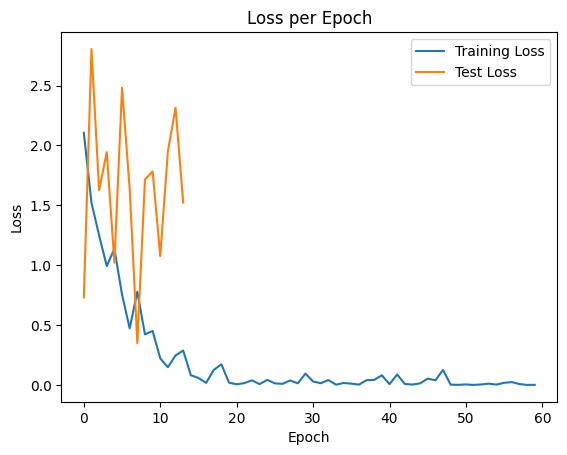

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
# GRAPH THE LOSS AT EPOCHS
# convert tensors to floats
train_loss_vals = [l.item() if isinstance(l, torch.Tensor) else float(l) for l in train_losses]
test_loss_vals  = [l.item() if isinstance(l, torch.Tensor) else float(l) for l in test_losses]

# Plot directly - already per-epoch
plt.plot(range(len(train_loss_vals)), train_loss_vals, label='Training Loss')
plt.plot(range(len(test_loss_vals)),  test_loss_vals,  label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

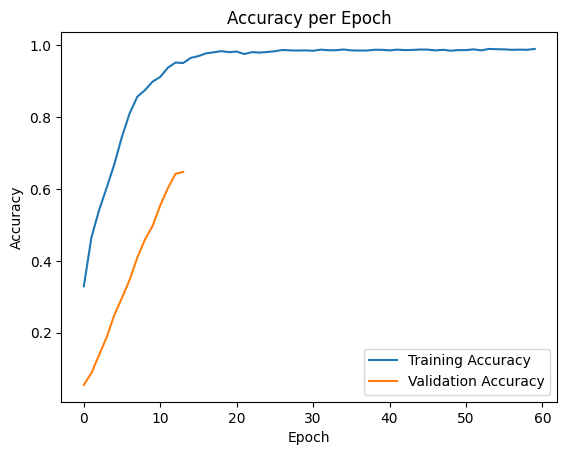

In [36]:
# GRAPH ACCURACY PER EPOCH
# Convert tensors to CPU and then to a list of numbers for plotting
train_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in train_correct]
test_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in test_correct]

plt.plot([t/2450 for t in train_correct_cpu], label='Training Accuracy') # Use the CPU version for plotting
plt.plot([t/420 for t in test_correct_cpu], label = 'Validation Accuracy') # Use the CPU version for plotting
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show() 

In [37]:
torch.save(model.state_dict(), 'Resnet_model(State_dict).pth')
torch.save(model, 'Resnet_model(Full model).pth')